In [1]:
!pipenv install pandas numpy matplotlib seaborn ipykernel
!pipenv shell

Installing pandas...

Installing numpy...
Installing matplotlib...
Installing seaborn...
Installing dependencies from Pipfile.lock (6e2922)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.



[    ] Installing..
[=   ] Installing pandas..
[==  ] Installing pandas..
[=== ] Installing pandas..
[ ===] Installing pandas..
[  ==] Installing pandas..
[   =] Installing pandas..
[    ] Installing pandas..
[   =] Installing pandas..
[  ==] Installing pandas..
[ ===] Installing pandas..
[====] Installing pandas..
[=== ] Installing pandas..
[==  ] Installing pandas..
[=   ] Installing pandas..
[    ] Installing pandas..
[=   ] Installing pandas..
[==  ] Installing pandas..
[=== ] Installing pandas..
[ ===] Installing pandas..
[  ==] Installing pandas..
[   =] Installing pandas..
[    ] Installing pandas..
[   =] Installing pandas..
[  ==] Installing pandas..
[ ===] Installing pandas..
[====] Installing pandas..
[=== ] Installing pandas..
[==  ] Installing pandas..
[=   ] Installing pandas..
[    ] Installing pandas..
[=   ] Installing pandas..
[==  ] Installing pandas..
[=== ] Installing pandas..
[ ===] Installing pandas..
[  ==] Installing pandas..
[   =] Installing pandas..
[    ] 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Load data/train_text.txt
# Each line represents a different tweet

with open('data/train_text.txt', encoding='utf-8') as f:
    tweets = f.readlines()

# Get tweets from test_text.txt and val_text.txt
with open('data/test_text.txt', encoding='utf-8') as f:
    tweets += f.readlines()

with open('data/val_text.txt', encoding='utf-8') as f:
    tweets += f.readlines()

# Pandas dataframe
tweets_df = pd.DataFrame(tweets, columns=['tweet'])
tweets_df.head()

,tweet
0,Sunday afternoon walking through Venice in the...
1,Time for some BBQ and whiskey libations. Chomp...
2,Love love love all these people ️ ️ ️ #friends...
3,"️ ️ ️ ️ @ Toys""R""Us \n"
4,Man these are the funniest kids ever!! That fa...


In [19]:
# Get every word in every tweet
# Split on whitespace
# Convert to lowercase

# Store in dictionary
# Key: word
# Value: count
word_counts = {}

for tweet in tweets:
    words = tweet.split()
    for word in words:
        word = word.lower()
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

In [20]:
# Get top 100 words
# Sort dictionary by value
# Convert to list of tuples
BEST_WORD_COUNT = 20
top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:BEST_WORD_COUNT]

c:\Users\Jeremias Ferrao\.virtualenvs\experimental-DjMT5kgn\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


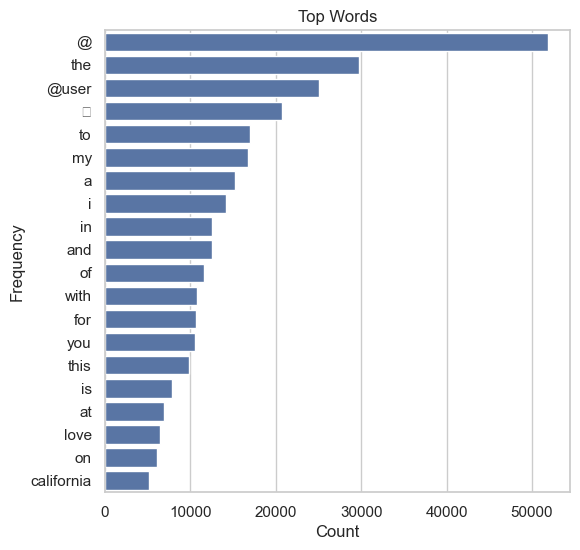

In [21]:
# plot the top words

sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.title('Top Words')
plt.xlabel('Count')
plt.ylabel('Frequency')
sns.barplot(x=[x[1] for x in top_words], y=[x[0] for x in top_words])
plt.show()